# Лінійна регресія. Прокат велосипедів

Курс: "Математичне моделювання в R"

---

::: {.callout-important}
# Перевірити матеріали лекції!!! 

Розділ про прогноз з кроком 10-30. Втрачено окремі комірки коду.
:::

In [1]:
# install.packages("mice")

## Dataset overview

Source: https://www.kaggle.com/c/bike-sharing-demand/data

**Dataset description:**

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Data Fields:**

- [x] `datetime` - hourly date + timestamp
- [x] `season` - 
    - [x] 1 = spring
    - [x] 2 = summer
    - [x] 3 = fall
    - [x] 4 = winter
- [x] `holiday` - whether the day is considered a holiday
- [x] `workingday` - whether the day is neither a weekend nor holiday
- [x] `weather`
    - [x] 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - [x] 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - [x] 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - [x] 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- [x] `temp` - temperature in Celsius
- [x] `atemp` - “feels like” temperature in Celsius
- [x] `humidity` - relative humidity
- [x] `windspeed` - wind speed
- [x] `casual` - number of non-registered user rentals initiated
- [x] `registered` - number of registered user rentals initiated
- [x] `count` - number of total rentals **(It is target variable. We will predict it!)**


In [2]:
data <- read.csv("data/bikes.csv")
head(data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


Описова статистика факторів:

In [3]:
summary(data)

   datetime             season         holiday          workingday    
 Length:10886       Min.   :1.000   Min.   :0.00000   Min.   :0.0000  
 Class :character   1st Qu.:2.000   1st Qu.:0.00000   1st Qu.:0.0000  
 Mode  :character   Median :3.000   Median :0.00000   Median :1.0000  
                    Mean   :2.507   Mean   :0.02857   Mean   :0.6809  
                    3rd Qu.:4.000   3rd Qu.:0.00000   3rd Qu.:1.0000  
                    Max.   :4.000   Max.   :1.00000   Max.   :1.0000  
    weather           temp           atemp          humidity     
 Min.   :1.000   Min.   : 0.82   Min.   : 0.76   Min.   :  0.00  
 1st Qu.:1.000   1st Qu.:13.94   1st Qu.:16.66   1st Qu.: 47.00  
 Median :1.000   Median :20.50   Median :24.24   Median : 62.00  
 Mean   :1.418   Mean   :20.23   Mean   :23.66   Mean   : 61.89  
 3rd Qu.:2.000   3rd Qu.:26.24   3rd Qu.:31.06   3rd Qu.: 77.00  
 Max.   :4.000   Max.   :41.00   Max.   :45.45   Max.   :100.00  
   windspeed          casual         regi

## Minimal data preprocessing

Перевіримо вибірку на наявність пропусків за допомогою функції `md.pattern()` з пакету `mice`:

In [4]:
anyNA(data)

[1] FALSE

In [5]:
library(mice)
md.pattern(data, F)


Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind




 /\     /\
{  `---'  }
{  O   O  }
==>  V <==  No need for mice. This data set is completely observed.
 \  \|/  /
  `-----'



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,
10886,1,1,1,1,1,1,1,1,1,1,1,1,0
,0,0,0,0,0,0,0,0,0,0,0,0,0


There are no missing data! Great for us!

Перетворимо категоріальні змінні до факторів:

In [6]:
data$season <- factor(data$season)
data$holiday <- factor(data$holiday)
data$workingday <- factor(data$workingday)
data$weather <- factor(data$weather)
data$holiday <- factor(data$holiday)

head(data) # preview data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1


У наборі даних наявні 3 вихідних параметра: `casual, `registered`, `count`, де $casual + registered = count$. Здійснимо прогноз `count`. Видалимо змінні, які використовуватися нами не будуть:

In [7]:
#data$casual <- NULL
#data$registered <- NULL

# or with dplyr
library(dplyr)
data <- data %>% select(-c(casual, registered))

head(data)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1


## Exploratory data analysis

Оцінимо звязки між числовими змінними та вихідним показником через кореляцію:

In [8]:
data %>%
 select(temp:count) %>% 
 cor() %>%
 as.data.frame()

,temp,atemp,humidity,windspeed,count
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
temp,1.00000000,0.98494811,-0.06494877,-0.01785201,0.3944536
atemp,0.98494811,1.00000000,-0.04353571,-0.05747300,0.3897844
humidity,-0.06494877,-0.04353571,1.00000000,-0.31860699,-0.3173715
windspeed,-0.01785201,-0.05747300,-0.31860699,1.00000000,0.1013695
count,0.39445364,0.38978444,-0.31737148,0.10136947,1.0000000


Щоб оглянути інформацію про частоту спостежень по сезонах варто скористатися записом:

In [9]:
data %>%
 group_by(season) %>%
 summarize(n = n())

season,n
<fct>,<int>
1,2686
2,2733
3,2733
4,2734


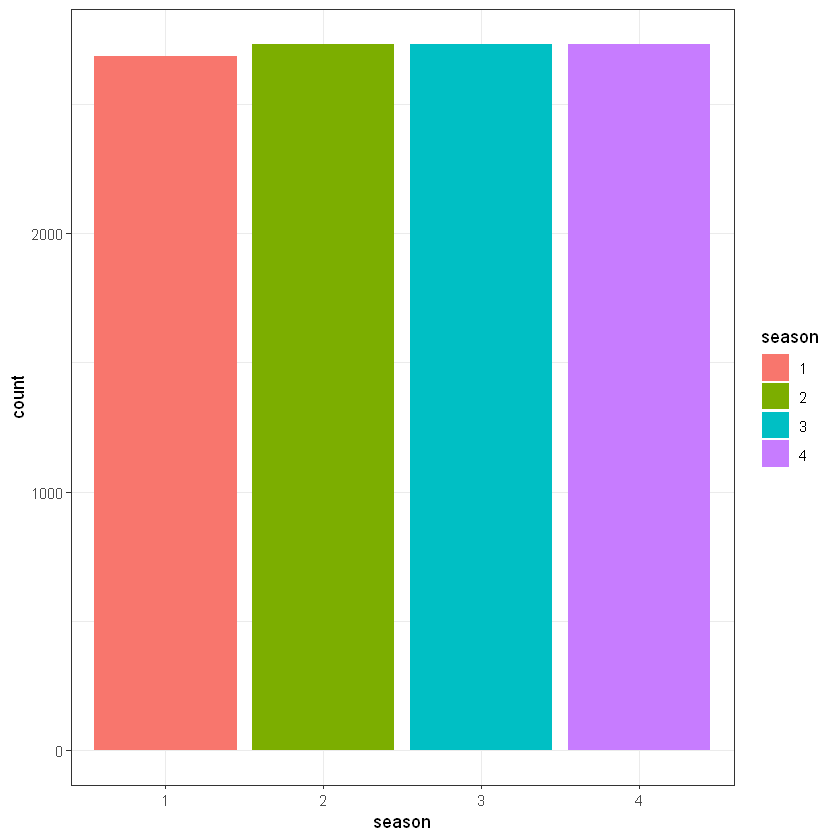

In [10]:
library(ggplot2)
# llok like we have almost the same count by each season
ggplot(data, aes(season)) + 
    geom_bar(aes(fill = season)) + 
    theme_bw()

holiday,n
<fct>,<int>
0,10575
1,311


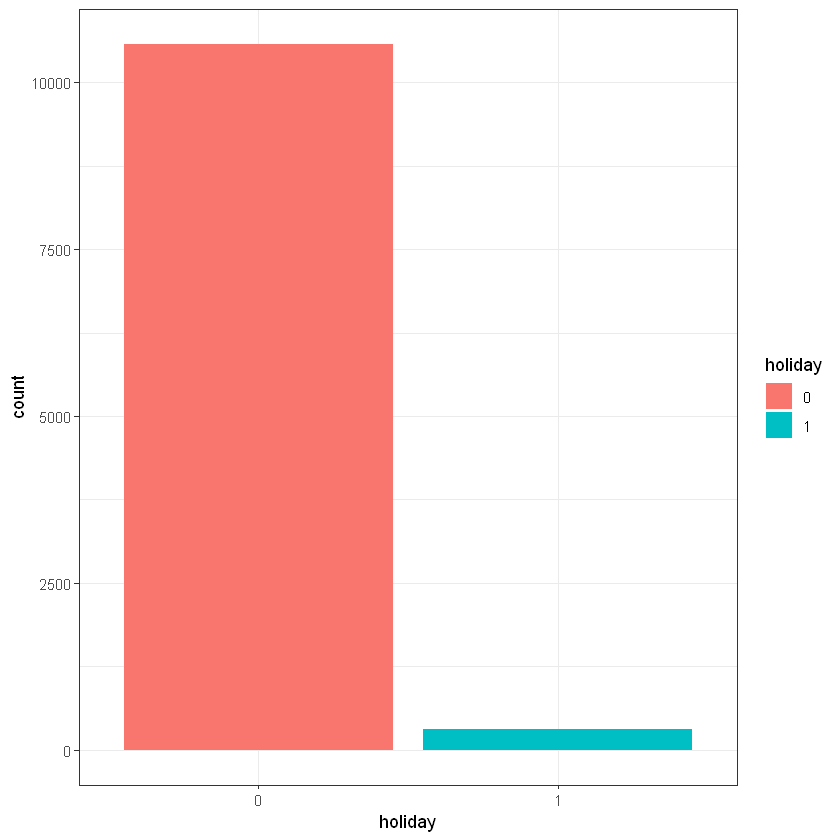

In [11]:
# Holidays plot
data %>%
 group_by(holiday) %>%
 summarize(n = n())

ggplot(data, aes(holiday)) + geom_bar(aes(fill = holiday)) + theme_bw()

workingday,n
<fct>,<int>
0,3474
1,7412


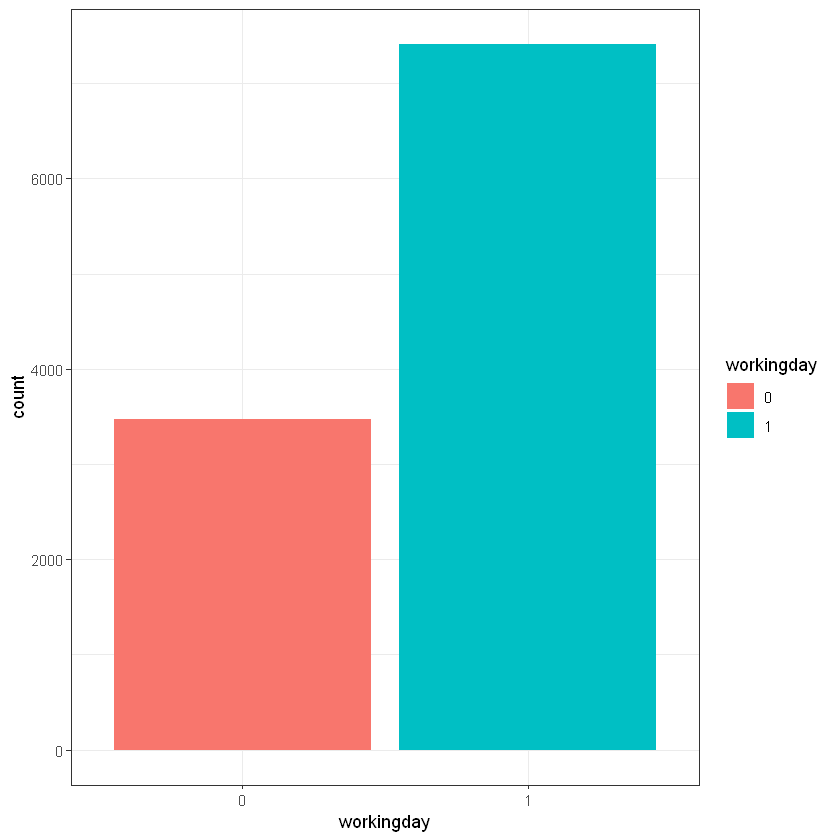

In [12]:
data %>%
 group_by(workingday) %>%
 summarize(n = n())

# Working dats plot
ggplot(data, aes(workingday)) + geom_bar(aes(fill = workingday)) + theme_bw()

- [x] `weather`
    - [x] 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - [x] 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - [x] 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - [x] 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

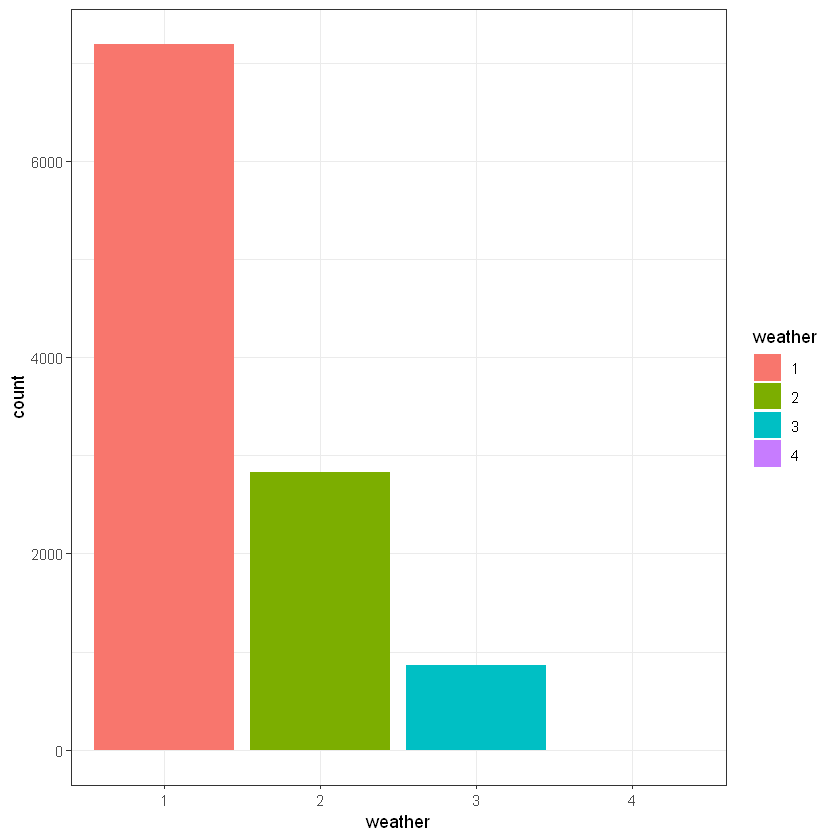

In [13]:
# weather plot
ggplot(data, aes(weather)) + geom_bar(aes(fill = weather)) + theme_bw()

Переглянемо також залежність між числовими факторами та кількістю прокатів байків. Для температури це матиме запис: 

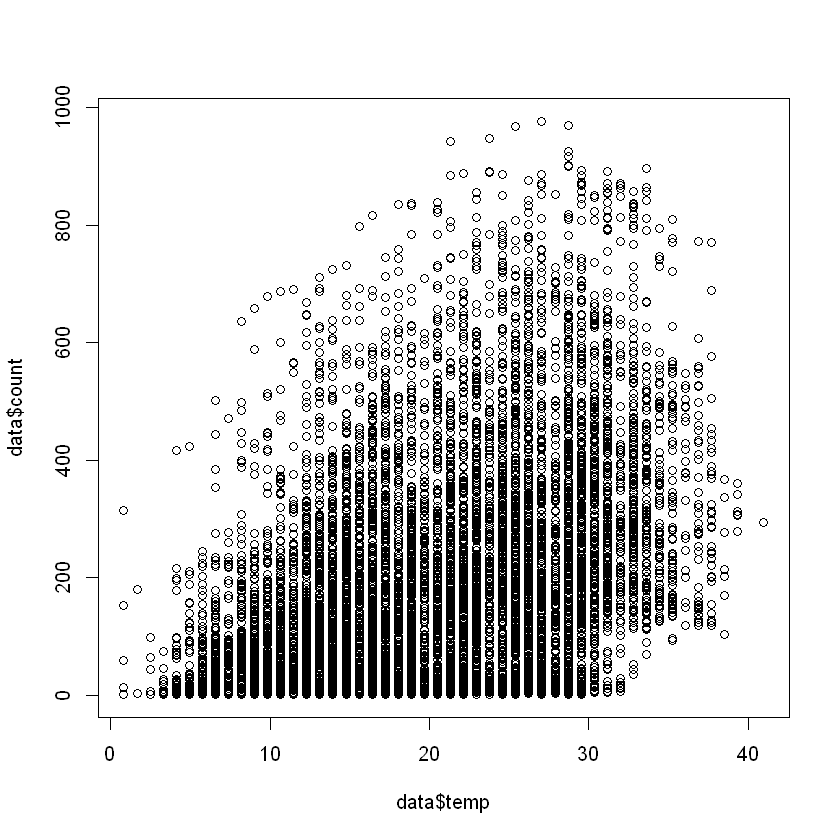

In [14]:
# temp
plot(x=data$temp, y=data$count)

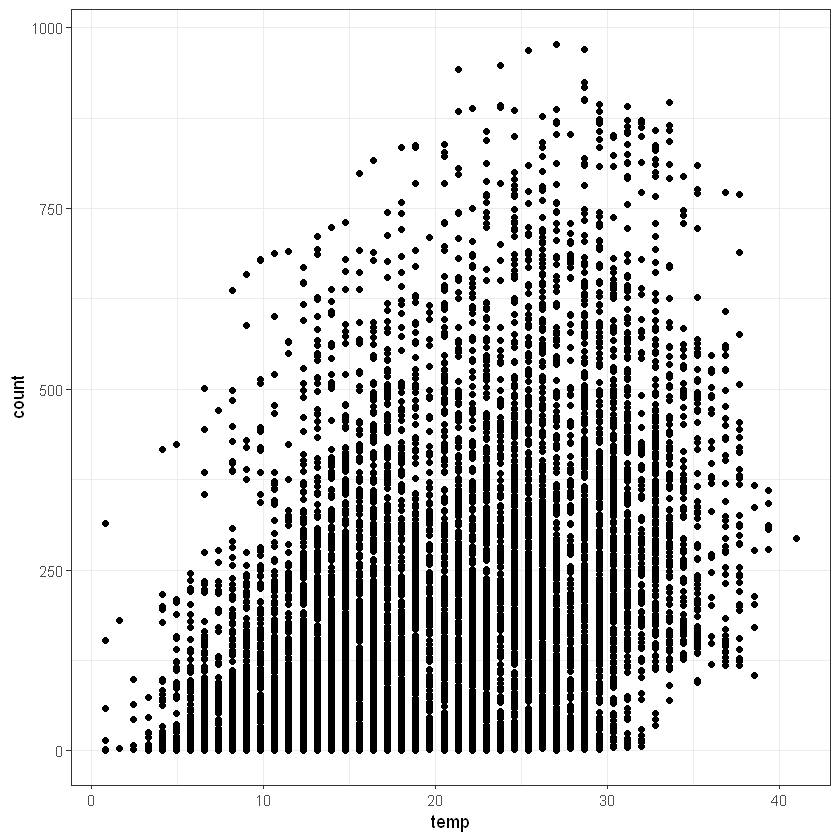

In [15]:
ggplot(data, aes(temp, count)) + geom_point() + theme_bw()

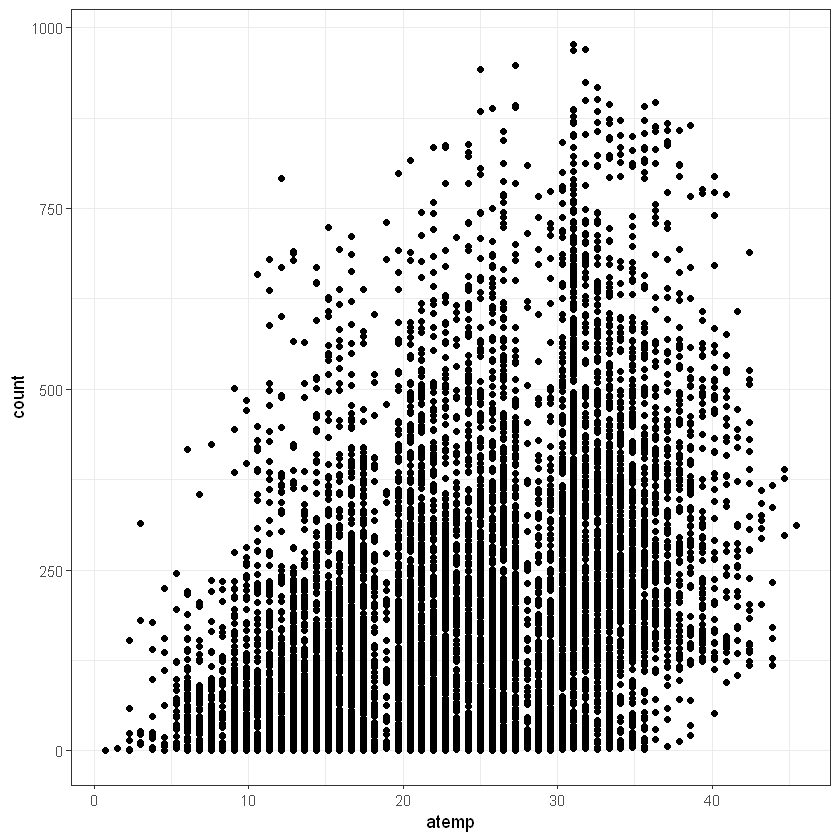

In [16]:
# atemp
ggplot(data, aes(atemp, count)) + geom_point() + theme_bw()

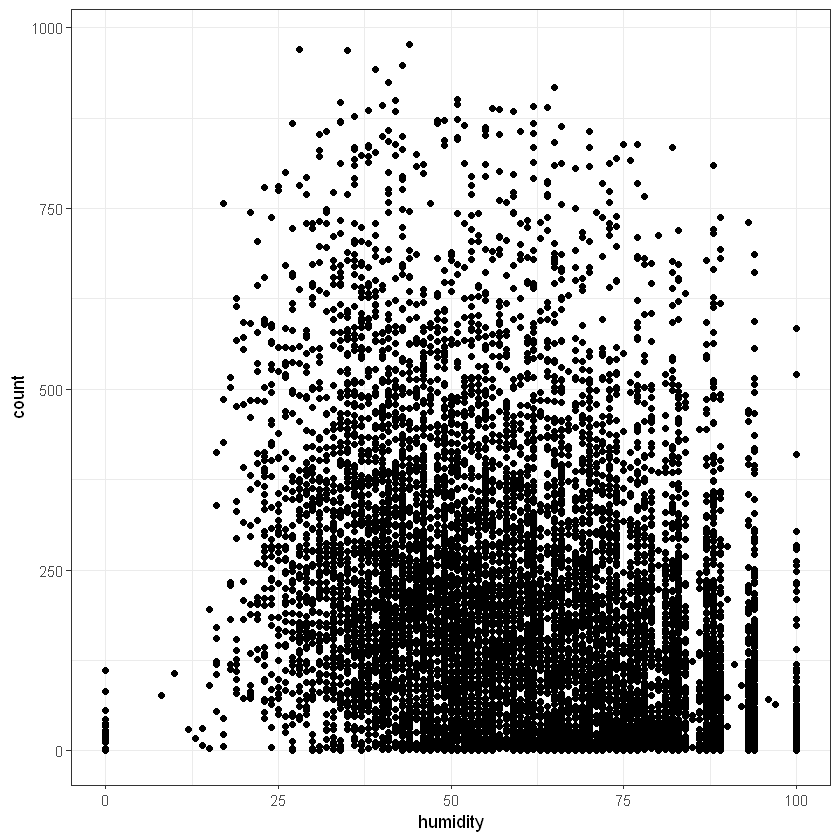

In [17]:
# humidity
ggplot(data, aes(humidity, count)) + geom_point() + theme_bw()

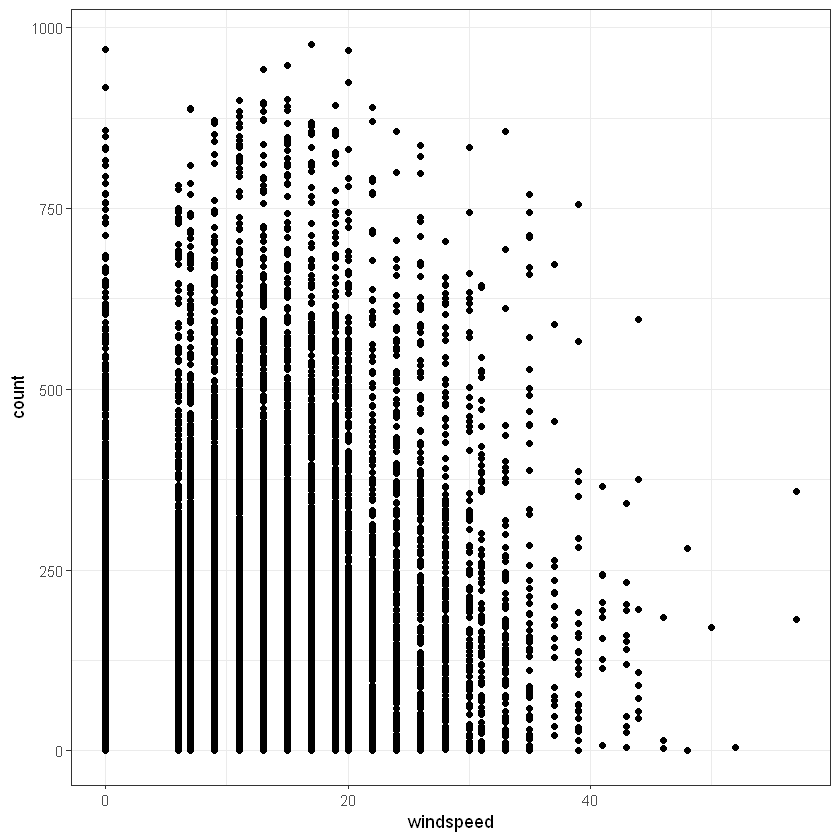

In [18]:
# windspeed
ggplot(data, aes(windspeed, count)) + geom_point() + theme_bw()

Переглянемо також загальний розподіл частоти замовлень байків на гістограмі:

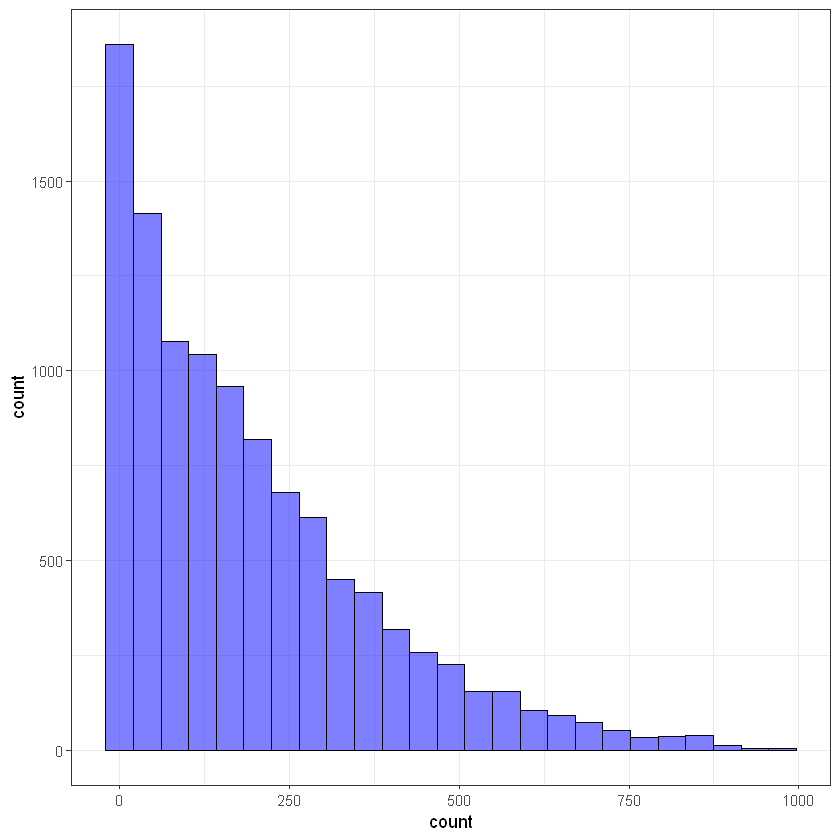

In [19]:
ggplot(data, aes(count)) + geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + theme_bw()

При спробі побудувати графік залежності між датою та кількістю замовлень байків ми отримаємо помилку або графік, що не відповідає порядку дат, оскільки на даний момент R не сприймає поле datetime як дату. Перетворимо дату за допомгою функції `as.POSIXct()`:

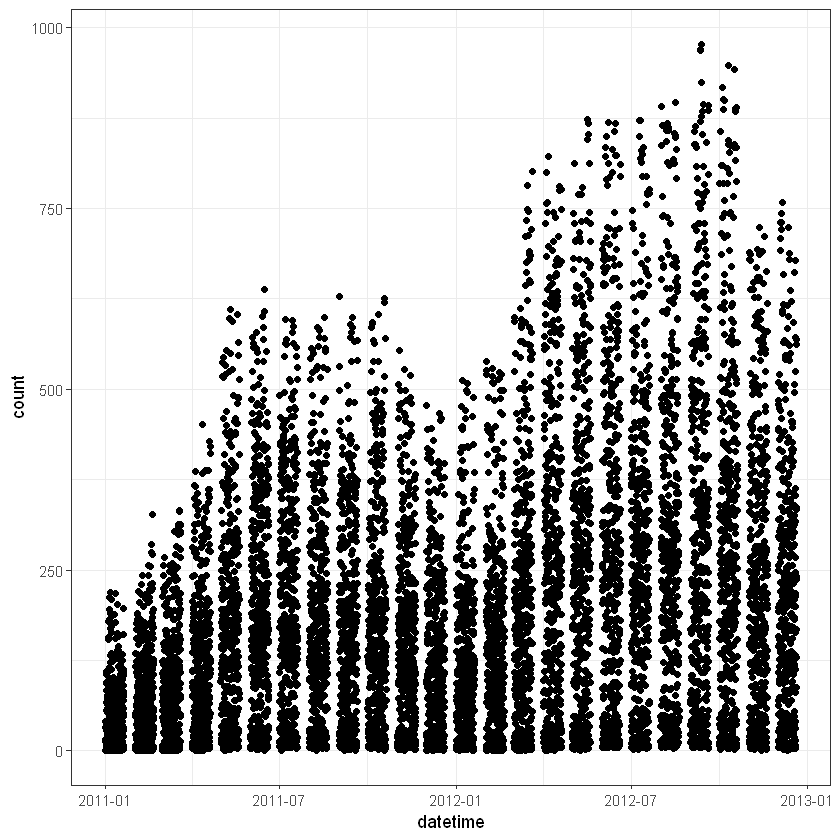

In [20]:
data$datetime <- as.POSIXct(data$datetime)
ggplot(data, aes(datetime, count)) + geom_point() + theme_bw()

Чи можна прослідкувати зміну кількості замовлень в залежності від пори року з цього графіку?

Покращити вигляд графіка можна додавання параметрів у `geom_point()`:

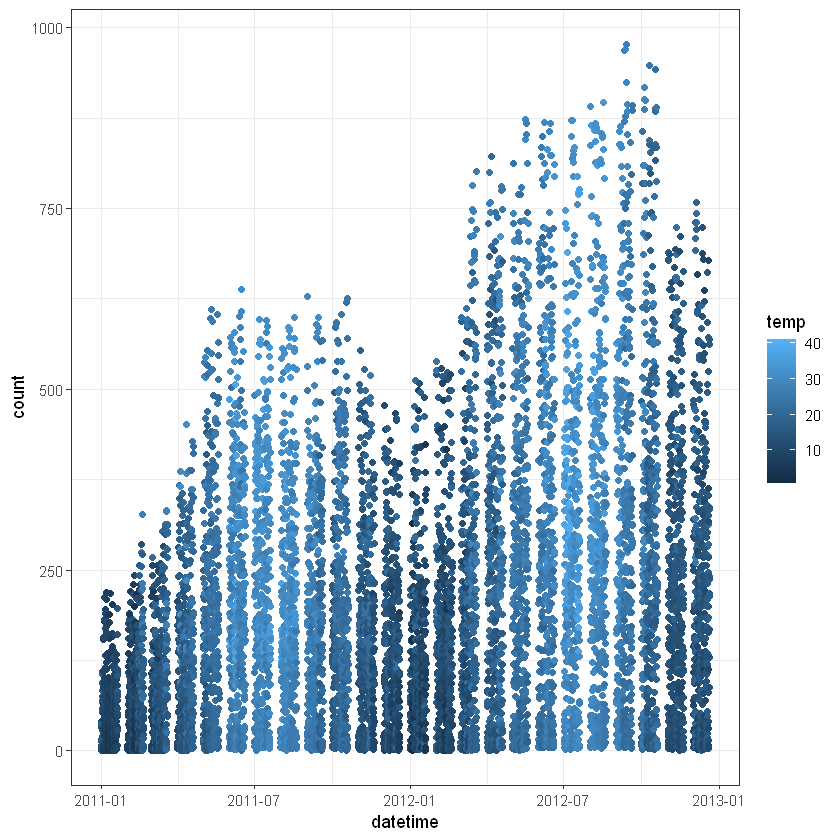

In [21]:
ggplot(data, aes(datetime, count)) + geom_point(aes(color=temp)) + theme_bw()

Переглянемо як час оренди байка впливає на кількість замовлень:

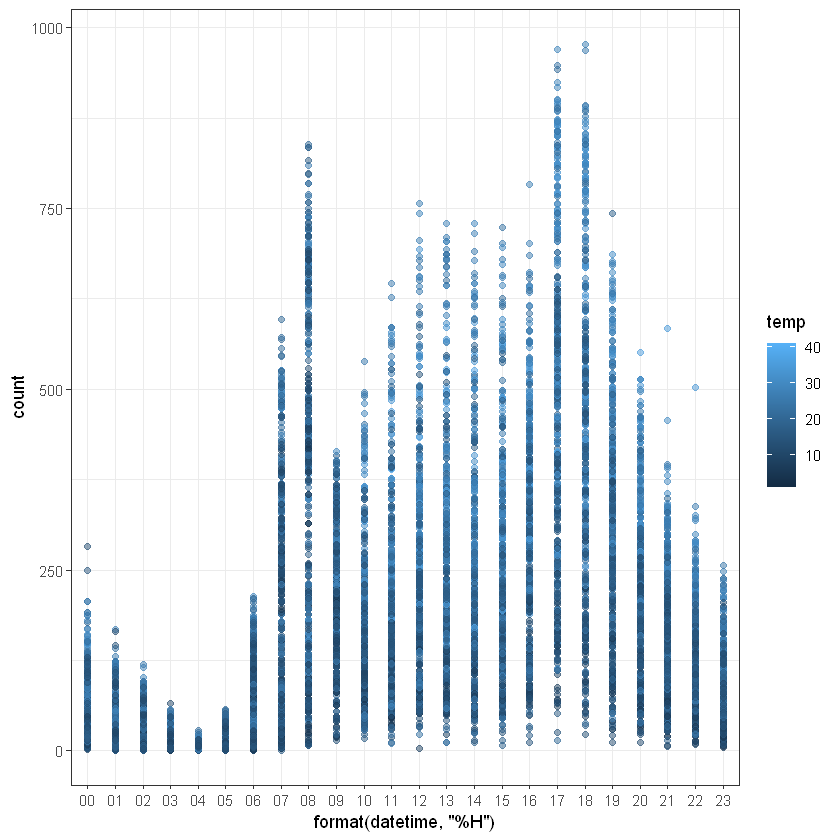

In [22]:
ggplot(data, aes(format(datetime, "%H"), count)) + 
        geom_point(aes(color=temp), alpha = 0.5) + 
        theme_bw()

Also, we can add new column to our dataset and use it:

In [23]:
data <- data %>%
    mutate(hour_rent = as.numeric(format(datetime, "%H")))
head(data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,5


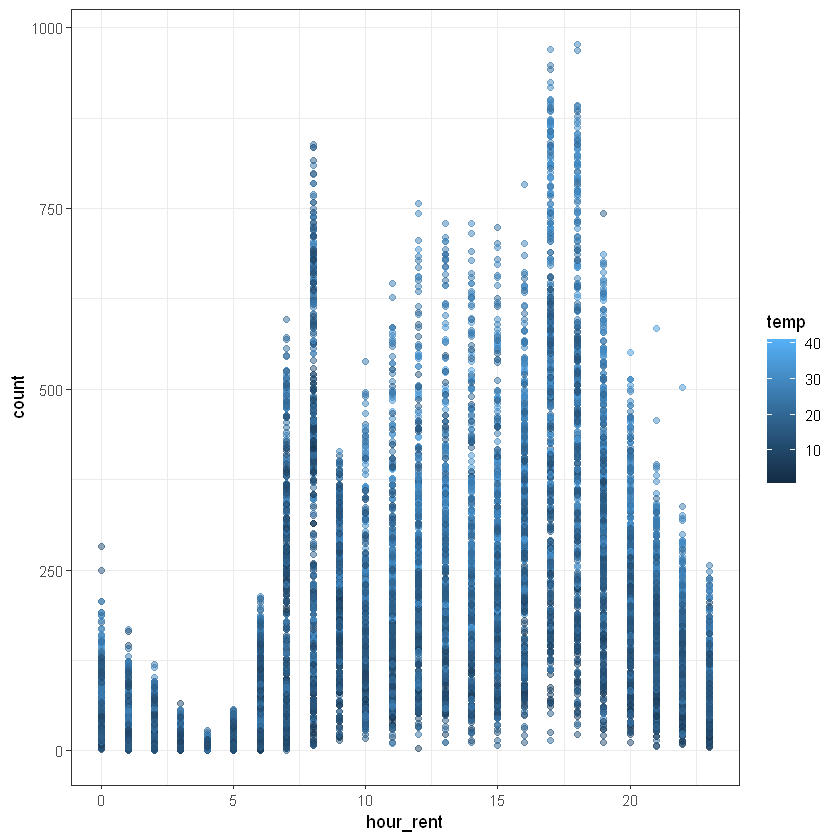

In [24]:
# the same chart as before
ggplot(data, aes(hour_rent, count)) + 
        geom_point(aes(color=temp), alpha = 0.5) + 
        theme_bw()

## Train test split

One more splitting method is based on date. So, we can use first 70% of dataset as train and 30% as test. This method often used for timeseries forecasting. We will use it for linear regression for now.

In [25]:
set.seed(10) 
nrow(data)

train_count = ceiling(0.7 * nrow(data))
train_count

test_count = nrow(data) - train_count
test_count

[1] 10886

[1] 7621

[1] 3265

In [26]:
data <- data %>% arrange(datetime) # sort by datetime

In [27]:
train_data <- data %>% slice_head(n = train_count)
nrow(train_data)
test_data <- data %>% slice_tail(n = test_count)
nrow(test_data)

[1] 7621

[1] 3265

In [28]:
# lets compare last from train and first from test
tail(train_data)
head(test_data) # ok!

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
7616,2012-05-16 16:00:00,2,0,1,1,29.52,32.575,45,7.0015,446,16
7617,2012-05-16 17:00:00,2,0,1,1,29.52,33.335,51,12.9980,873,17
7618,2012-05-16 18:00:00,2,0,1,1,29.52,33.335,51,15.0013,846,18
7619,2012-05-16 19:00:00,2,0,1,1,28.70,32.575,54,19.0012,590,19
7620,2012-05-16 20:00:00,2,0,1,1,27.06,31.060,65,16.9979,459,20
7621,2012-05-16 21:00:00,2,0,1,1,26.24,30.305,73,12.9980,393,21


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
1,2012-05-16 22:00:00,2,0,1,1,26.24,30.305,73,11.0014,286,22
2,2012-05-16 23:00:00,2,0,1,1,25.42,29.545,78,7.0015,133,23
3,2012-05-17 00:00:00,2,0,1,1,24.60,28.790,78,8.9981,79,0
4,2012-05-17 01:00:00,2,0,1,1,24.60,28.030,83,11.0014,28,1
5,2012-05-17 02:00:00,2,0,1,1,24.60,28.790,78,11.0014,16,2
6,2012-05-17 03:00:00,2,0,1,1,24.60,29.545,73,16.9979,3,3


---

## Model building

Побудуємо напройстішу модель залежності середньої температури за день та кількості орендованих байків:

In [29]:
lm_bike <- lm(count ~ atemp, train_data)
summary(lm_bike)


Call:
lm(formula = count ~ atemp, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-254.42  -93.91  -27.43   65.57  648.09 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.0774     4.4973  -0.462    0.644    
atemp         7.2602     0.1895  38.311   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 138.4 on 7619 degrees of freedom
Multiple R-squared:  0.1615,	Adjusted R-squared:  0.1614 
F-statistic:  1468 on 1 and 7619 DF,  p-value: < 2.2e-16


Спробуємо порахувати кількість орендованих байків для середніх темпертур від 10 до 30 градусів.

Створимо датафрейм з послідовністю елементів 10-30 з кроком 1 та порахуємо за формулою з інформації про модель прогнозовані показники:

Здійснимо прогноз за допомогою функції `predict()`:

In [30]:
#predict_1030$count_model <- predict(lm_bike, newdata = predict_1030)
#predict_1030 %>% head()

# our results are very close, minimal difference is a result of rounding numbers in our formula

In [31]:
# how it looks like at chart
#ggplot(predict_1030, aes(atemp, count_model)) + 
 #       geom_point() + 
    #    theme_bw()

Побудуємо модель для усіх параметрів моделі окрім дати:

In [32]:
lm_bike <- lm(count~.-datetime, train_data)
summary(lm_bike)


Call:
lm(formula = count ~ . - datetime, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-283.67  -78.72  -25.68   46.27  587.17 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  15.67996    8.85332   1.771   0.0766 .  
season2       9.39674    4.59288   2.046   0.0408 *  
season3     -40.29356    6.46891  -6.229 4.95e-10 ***
season4      21.14562    4.40422   4.801 1.61e-06 ***
holiday1     -8.46508    8.79408  -0.963   0.3358    
workingday1  -4.89327    3.12276  -1.567   0.1172    
weather2      2.76675    3.47283   0.797   0.4257    
weather3    -31.30849    5.61763  -5.573 2.59e-08 ***
weather4     85.56066  122.62585   0.698   0.4854    
temp          1.34075    1.67470   0.801   0.4234    
atemp         6.30809    1.48446   4.249 2.17e-05 ***
humidity     -1.49856    0.08884 -16.868  < 2e-16 ***
windspeed     0.35086    0.19131   1.834   0.0667 .  
hour_rent     6.20760    0.21640  28.685  < 2e-16 ***
---
Signif. codes:  

Перевіримо модель на мультиколінеарність:

In [33]:
library(car)
vif(lm_bike)

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode




,GVIF,Df,GVIF^(1/(2*Df))
season,2.941744,3,1.197018
holiday,1.076162,1,1.037382
workingday,1.072163,1,1.035453
weather,1.291207,3,1.043516
temp,83.073739,1,9.114480
atemp,78.281362,1,8.847676
humidity,1.594124,1,1.262586
windspeed,1.331723,1,1.154003
hour_rent,1.135437,1,1.065569


Виключимо корельовані показники з моделі за принципом - залишити той, що має вищу кореляцію із залежним фактором. У нашому випадку це `temp`:

In [34]:
lm_bike <- lm(count~.-datetime-atemp, train_data)
summary(lm_bike)


Call:
lm(formula = count ~ . - datetime - atemp, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-297.02  -79.11  -25.60   46.35  585.12 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  26.97221    8.45456   3.190  0.00143 ** 
season2       9.25257    4.59790   2.012  0.04422 *  
season3     -45.22396    6.37114  -7.098 1.38e-12 ***
season4      22.00064    4.40455   4.995 6.02e-07 ***
holiday1    -11.34365    8.77778  -1.292  0.19629    
workingday1  -4.86349    3.12625  -1.556  0.11982    
weather2      3.02977    3.47616   0.872  0.38346    
weather3    -32.19037    5.62008  -5.728 1.06e-08 ***
weather4     88.33390  122.76150   0.720  0.47182    
temp          8.34447    0.29736  28.062  < 2e-16 ***
humidity     -1.47674    0.08879 -16.632  < 2e-16 ***
windspeed     0.06683    0.17945   0.372  0.70959    
hour_rent     6.20731    0.21665  28.652  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Далі побудуємо модель на основі алгоритму stepwise та порівняємо з поточними характеристиками моделі.

Створимо моделі для проходів у два боки:

In [35]:
start_mod <- lm(count ~ 1, data = train_data)
end_mod <- lm(count ~ . - datetime - temp, data = train_data)

Запустимо алгоритм функцією `step()`:

In [36]:
lm_bike_stepwise <- step(start_mod,
                     scope = list(lower = start_mod, upper = end_mod),
                     direction = "both", trace = 1, steps = 1000)

Start:  AIC=76488.12
count ~ 1

             Df Sum of Sq       RSS   AIC
+ atemp       1  28114587 145942663 75148
+ hour_rent   1  27600736 146456514 75174
+ humidity    1  15503642 158553609 75779
+ season      3   9131936 164925314 76083
+ weather     3   3537078 170520172 76338
+ windspeed   1   2112392 171944858 76397
<none>                    174057250 76488
+ holiday     1     12170 174045081 76490
+ workingday  1      3511 174053739 76490

Step:  AIC=75147.53
count ~ atemp

             Df Sum of Sq       RSS   AIC
+ hour_rent   1  20603748 125338915 73990
+ humidity    1  15576942 130365721 74289
+ season      3   5178271 140764392 74878
+ weather     3   2989985 142952678 74996
+ windspeed   1   2889374 143053289 74997
<none>                    145942663 75148
+ workingday  1     34765 145907898 75148
+ holiday     1        44 145942619 75150
- atemp       1  28114587 174057250 76488

Step:  AIC=73989.67
count ~ atemp + hour_rent

             Df Sum of Sq       RSS   AIC
+ 

In [37]:
# check the summary
summary(lm_bike_stepwise)


Call:
lm(formula = count ~ atemp + hour_rent + humidity + season + 
    weather + windspeed, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-285.56  -78.70  -25.63   47.20  586.14 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.56655    8.35898   1.264   0.2062    
atemp         7.46224    0.26269  28.407  < 2e-16 ***
hour_rent     6.21766    0.21626  28.750  < 2e-16 ***
humidity     -1.50051    0.08851 -16.954  < 2e-16 ***
season2       9.95637    4.55753   2.185   0.0289 *  
season3     -38.55100    6.14342  -6.275 3.68e-10 ***
season4      21.22676    4.40003   4.824 1.43e-06 ***
weather2      2.68041    3.47136   0.772   0.4400    
weather3    -31.47986    5.60817  -5.613 2.06e-08 ***
weather4     83.31112  122.62122   0.679   0.4969    
windspeed     0.40641    0.17932   2.266   0.0235 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 122.5 on 7610 degrees of freedom
Mult

$R^2$ increses!

Об’єднаємо для наочності коефіцієнти у один датафрейм:

In [38]:
lm_coefs_def <- data.frame(lm_name = names(lm_bike$coefficients),
                           name = lm_bike$coefficients, 
                           row.names = c() # cleaning rownames
                          )
lm_coefs_def

lm_name,name
<chr>,<dbl>
(Intercept),26.97221255
season2,9.25256711
season3,-45.22395805
season4,22.00064078
holiday1,-11.34364536
workingday1,-4.86348665
weather2,3.02977126
weather3,-32.19036573
weather4,88.33390060


In [39]:
lm_coefs_sw <- data.frame(lm_name = names(lm_bike_stepwise$coefficients), name = lm_bike_stepwise$coefficients, row.names = c())
lm_coefs_sw

lm_name,name
<chr>,<dbl>
(Intercept),10.5665521
atemp,7.4622378
hour_rent,6.2176579
humidity,-1.5005074
season2,9.9563690
season3,-38.5510028
season4,21.2267554
weather2,2.6804117
weather3,-31.4798561


In [40]:
# lets combine coefficients from both models
lm_coefs <- merge(lm_coefs_def, lm_coefs_sw, by = "lm_name", X.all = T, X.all = T)
colnames(lm_coefs) <- c("variable", "lm", "lm_sw")
lm_coefs

variable,lm,lm_sw
<chr>,<dbl>,<dbl>
(Intercept),26.97221255,10.5665521
hour_rent,6.20730753,6.2176579
humidity,-1.47674448,-1.5005074
season2,9.25256711,9.9563690
season3,-45.22395805,-38.5510028
season4,22.00064078,21.2267554
weather2,3.02977126,2.6804117
weather3,-32.19036573,-31.4798561
weather4,88.33390060,83.3111193


Як бачимо моделі мають незначні відмінності.

---

## Model errors analysis

Запишемо у `train` набір даних модельовані значення `count` та похибки:

In [41]:
train_data$predicted <- lm_bike$fitted.values
train_data$residuals <- lm_bike$residuals
head(train_data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent,predicted,residuals
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,0,-10.534505,26.534505
2,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,1,-9.692918,49.692918
3,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2,-3.485611,35.485611
4,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,3,16.947885,-3.947885
5,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,4,23.155192,-22.155192
6,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,1,5,32.793480,-31.793480


Візуалізуємо відхилення моделі:

In [42]:
plot_data <- train_data[1:100,]

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


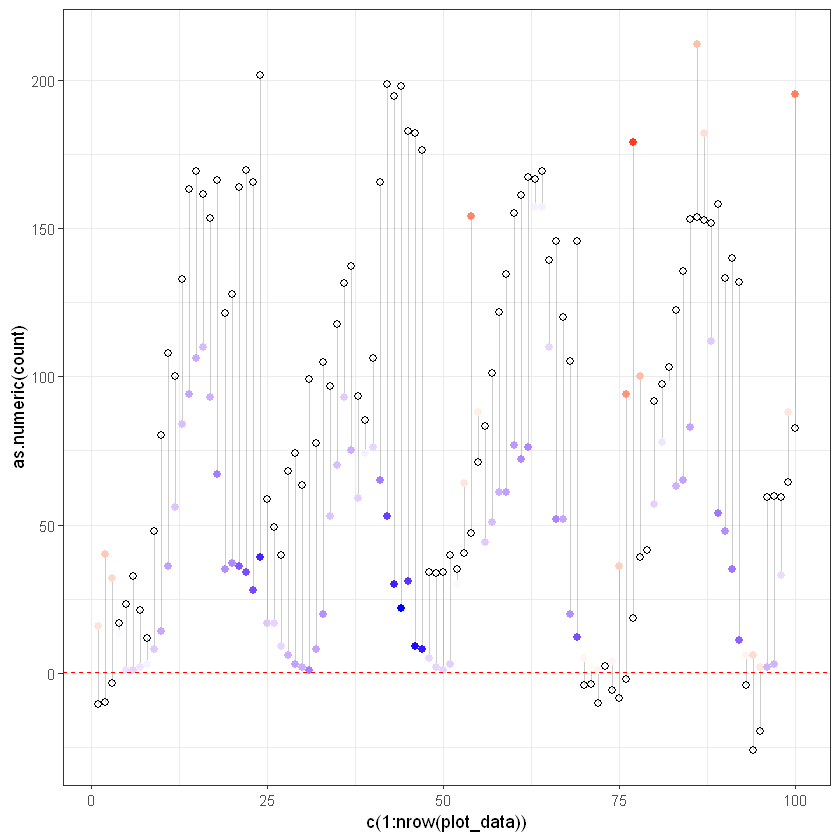

In [43]:
ggplot(plot_data, aes(x = c(1:nrow(plot_data)), y = as.numeric(count))) +
  geom_segment(aes(xend = c(1:nrow(plot_data)), yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals), size = 2) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1, size = 2) +
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_bw()

Lets check the same for test data

First we need to predict values:

In [44]:
test_data$predicted <- predict(lm_bike, newdata = test_data)
head(test_data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent,predicted
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
1,2012-05-16 22:00:00,2,0,1,1,26.24,30.305,73,11.0014,286,22,279.8139
2,2012-05-16 23:00:00,2,0,1,1,25.42,29.545,78,7.0015,133,23,271.5277
3,2012-05-17 00:00:00,2,0,1,1,24.60,28.790,78,8.9981,79,0,122.0506
4,2012-05-17 01:00:00,2,0,1,1,24.60,28.030,83,11.0014,28,1,121.0080
5,2012-05-17 02:00:00,2,0,1,1,24.60,28.790,78,11.0014,16,2,134.5991
6,2012-05-17 03:00:00,2,0,1,1,24.60,29.545,73,16.9979,3,3,148.5908


In [45]:
# resulduals calculation
test_data$residuals <- test_data$count - test_data$predicted
head(test_data)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour_rent,predicted,residuals
,<dttm>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,2012-05-16 22:00:00,2,0,1,1,26.24,30.305,73,11.0014,286,22,279.8139,6.186142
2,2012-05-16 23:00:00,2,0,1,1,25.42,29.545,78,7.0015,133,23,271.5277,-138.527654
3,2012-05-17 00:00:00,2,0,1,1,24.60,28.790,78,8.9981,79,0,122.0506,-43.050553
4,2012-05-17 01:00:00,2,0,1,1,24.60,28.030,83,11.0014,28,1,121.0080,-93.008024
5,2012-05-17 02:00:00,2,0,1,1,24.60,28.790,78,11.0014,16,2,134.5991,-118.599054
6,2012-05-17 03:00:00,2,0,1,1,24.60,29.545,73,16.9979,3,3,148.5908,-145.590844


In [46]:
plot_data <- test_data[1:100,]

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


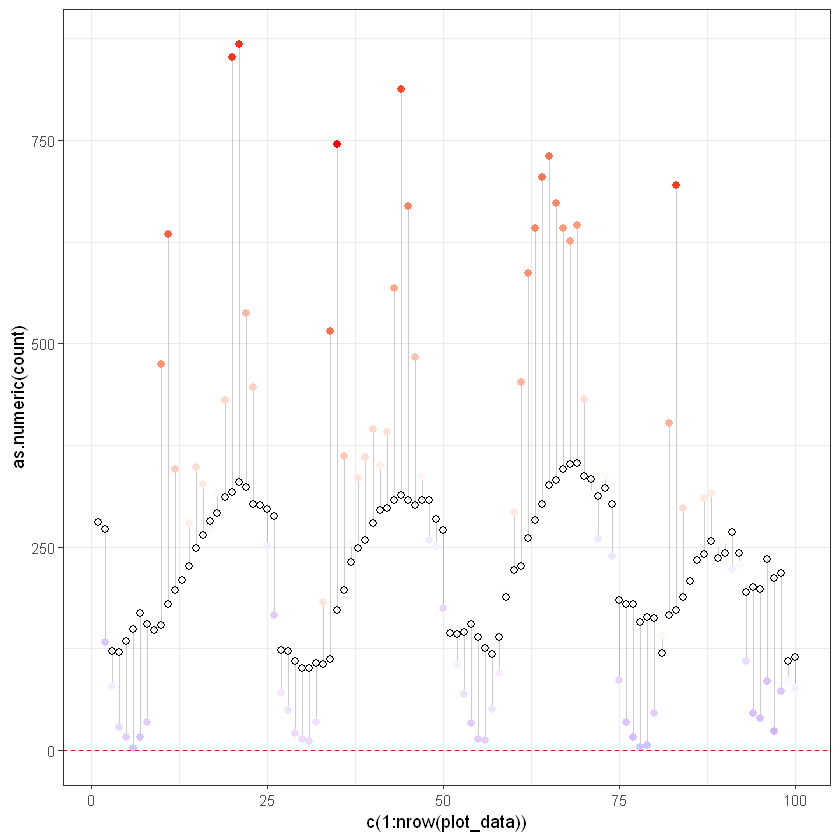

In [47]:
ggplot(plot_data, aes(x = c(1:nrow(plot_data)), y = as.numeric(count))) +
  geom_segment(aes(xend = c(1:nrow(plot_data)), yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals), size = 2) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 1, size = 2) +
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_bw()

In [48]:
library(modelr)
resids <- data.frame(
  R2 = c(rsquare(lm_bike, data = train_data), rsquare(lm_bike, data = test_data)),
  MSE = c(mse(lm_bike, data = train_data),mse(lm_bike, data = test_data)),
  RMSE = c(rmse(lm_bike, data = train_data), rmse(lm_bike, data = test_data))#,
  #MAE = c(mae(lm_bike, data = train_data), mae(lm_bike, data = test_data)), # if needed 
  #MAPE = c(mape(lm_bike, data = train_data), mape(lm_bike, data = test_data)) # if needed
)
          
rownames(resids) <- c("train", "test") # give names for rows

resids

,R2,MSE,RMSE
,<dbl>,<dbl>,<dbl>
train,0.3422443,15022.59,122.5667
test,0.2854741,40401.94,201.0023


**Conclusion:** Test set has less RSquared and Bigger Errors variation. Train dataset is closer, because it built on training data and model include information about data.

---